# <span style="background-color: #FFA45B"> Augmented Image Version</span>


Since we are augmenting our images, our team thinks that it will be a good idea to try to oversample our normal images through augmentation so that we can have the same number of images in each class. This way, we are able to have more data to train our model and hopefully, our model will be able to perform better.

I will be using sklearn to generate more image for the normal class as it is serverely lacking in dataset. However, this can introduce more problems as augmenting one class disrupt how the class should be and since both classes images are pretty simialr, the model might perform worse compare to be undersampling the images. But this project serves as a platform for me to experiment with the different changes and learning something by the end of it.


Loading: 100%|##########| 2690/2690 [00:08<00:00, 325.33it/s]


Number of normal images:  4273
Number of pneumonia images:  4273


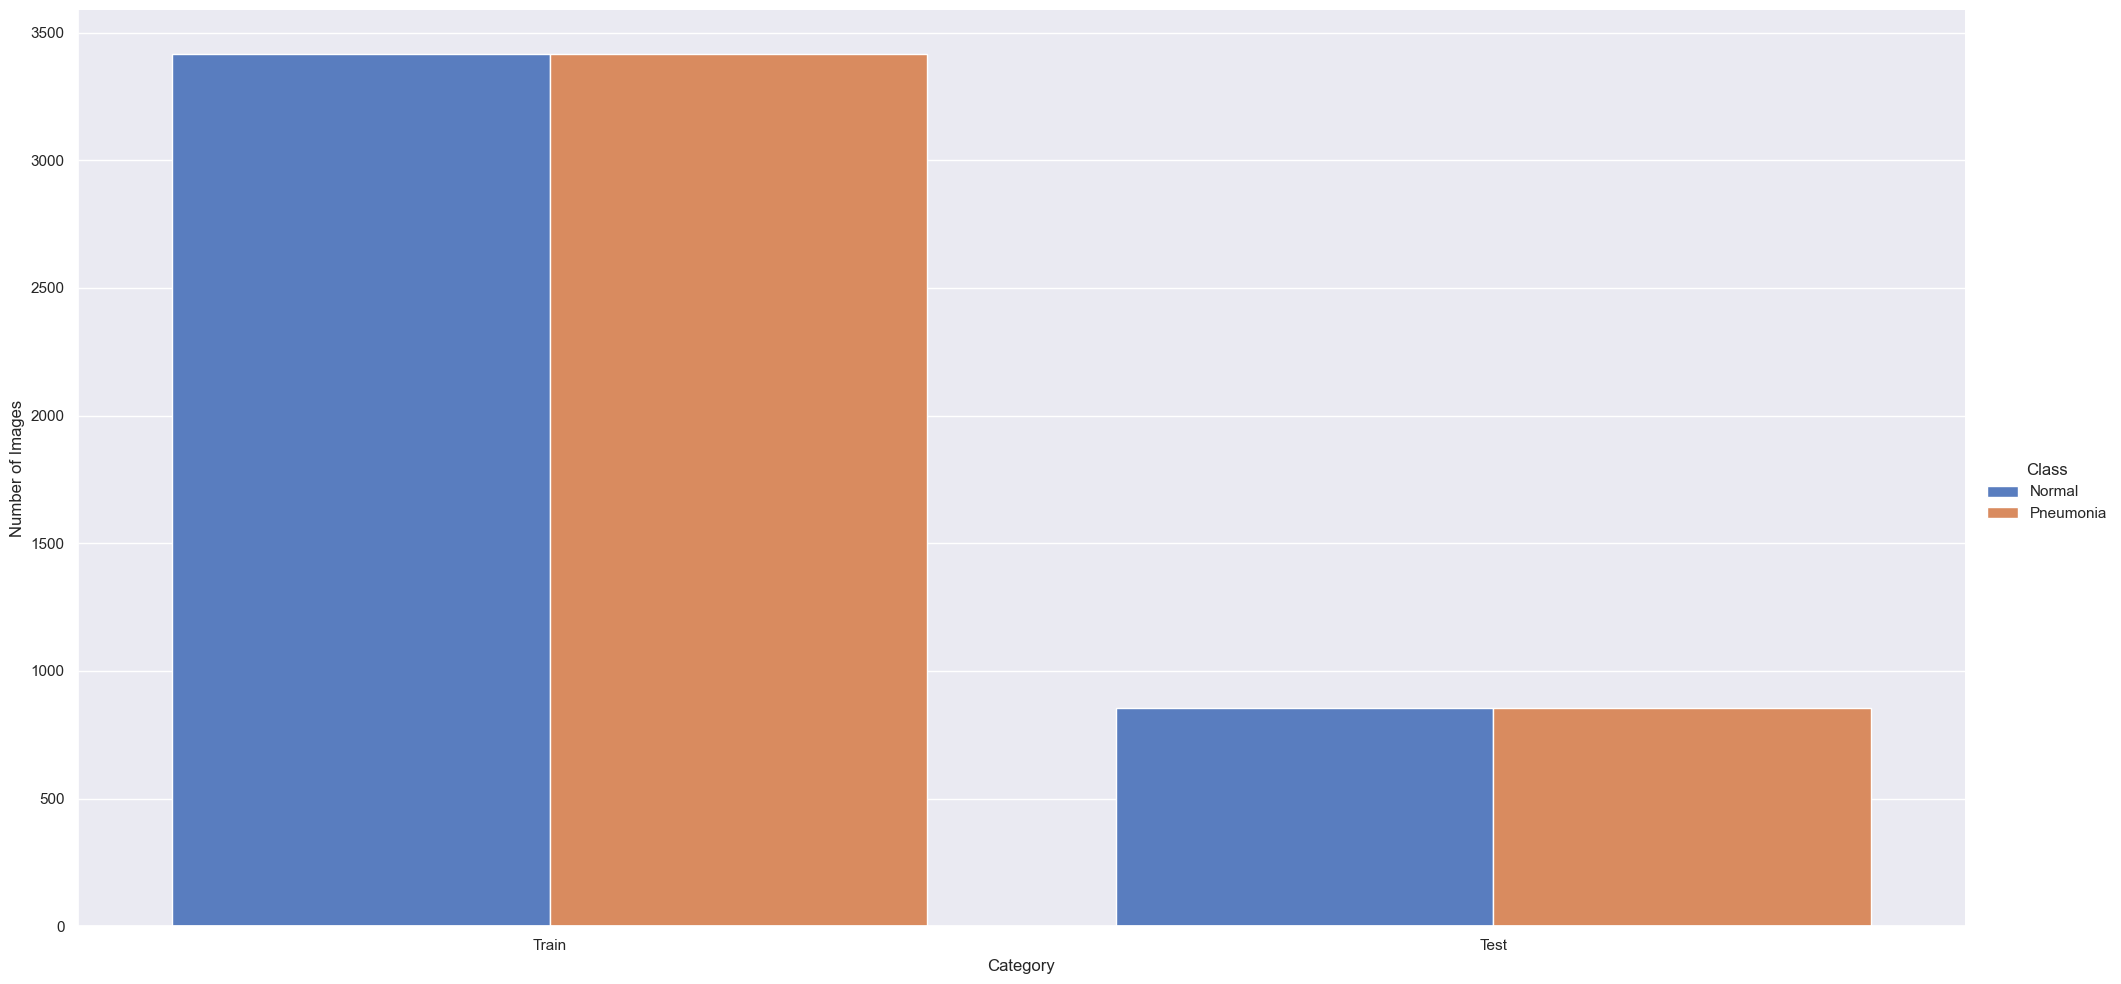

In [ ]:
# Directories
train_dir = './crop_images/train'
val_dir = './crop_images/val'
test_dir = './crop_images/test'

oversample_norm_dir = "./oversample_norm"

if not os.path.exists(oversample_norm_dir):
    os.mkdir(oversample_norm_dir)

# Check the number of images in each classes in the respecitve sets and plot them

train_normal_images = [train_dir + "/NORMAL/" + f for f in os.listdir(train_dir + "/NORMAL")]
train_pneumonia_images = [train_dir + "/PNEUMONIA/" + f for f in os.listdir(train_dir + "/PNEUMONIA")]

val_normal_images = [val_dir + "/NORMAL/" + f for f in os.listdir(val_dir + "/NORMAL")]
val_pneumonia_images = [val_dir + "/PNEUMONIA/" + f for f in os.listdir(val_dir + "/PNEUMONIA")]

test_normal_images = [test_dir + "/NORMAL/" + f for f in os.listdir(test_dir + "/NORMAL")]
test_pneumonia_images = [test_dir + "/PNEUMONIA/" + f for f in os.listdir(test_dir + "/PNEUMONIA")]

# Create a dataframe with the path of the images and the labels
normal_images_list = train_normal_images + val_normal_images + test_normal_images
pneumonia_images_list = train_pneumonia_images + val_pneumonia_images + test_pneumonia_images

# Shuffle the images
random.shuffle(normal_images_list)
random.shuffle(pneumonia_images_list)

# Create a dictionary to store all the transformation functions
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

if len(os.listdir(oversample_norm_dir)) <= 1:
    # Oversampling the normal images through data augmentation
    for i in tqdm(range((len(pneumonia_images_list) - len(normal_images_list))), ascii=True, desc='Loading'):
        # Augment the image twice with any random available transformation
        augmented_image = available_transformations[random.choice(list(available_transformations))]((sk.io.imread(normal_images_list[i%1583])*255).astype(np.uint8))
        augmented_image = available_transformations[random.choice(list(available_transformations))]((augmented_image*255).astype(np.uint8))

        # Save the image
        sk.io.imsave(oversample_norm_dir + "/" + str(i) + ".jpg", (augmented_image*255).astype(np.uint8))
else:
    print("Oversampled images already exist")

# Append to list
oversample_norm_images = [oversample_norm_dir + "/" + f for f in os.listdir(oversample_norm_dir)]

# Concat the oversampled images to the normal images
normal_images_list = normal_images_list + oversample_norm_images

print("Number of normal images: ", len(normal_images_list))
print("Number of pneumonia images: ", len(pneumonia_images_list))

# Shuffle the images
random.shuffle(normal_images_list)
random.shuffle(pneumonia_images_list)

# Split each classes into 80% training,20% testing
train_normal_images_aug, test_normal_images_aug = train_test_split(normal_images_list, test_size=0.2, random_state=42)
train_pneumonia_images_aug, test_pneumonia_images_aug = train_test_split(pneumonia_images_list, test_size=0.2, random_state=42)


# Plot the number of image in each class with respect to its set

aug_num_images_df = pd.DataFrame({'Category': ['Train', 'Test'], 'Normal': [len(train_normal_images_aug), len(test_normal_images_aug)], 'Pneumonia': [len(train_pneumonia_images_aug), len(test_pneumonia_images_aug)]})
aug_num_images_df = pd.melt(aug_num_images_df, id_vars="Category", var_name="Class", value_name="Number of Images")

sb.catplot(data = aug_num_images_df, x="Category", y= "Number of Images", hue="Class", kind="bar", height= 10, aspect=2, palette="muted")


# Create seperate dataframe for train and test set with the label NORMAL and PNUEMONIA
aug_train_df = pd.DataFrame({'path': train_normal_images + train_pneumonia_images, 'label': ['NORMAL'] * len(train_normal_images) + ['PNEUMONIA'] * len(train_pneumonia_images)})
aug_test_df = pd.DataFrame({'path': test_normal_images + test_pneumonia_images, 'label': ['NORMAL'] * len(test_normal_images) + ['PNEUMONIA'] * len(test_pneumonia_images)})



Now we see that both classes have the same amount of images and the quantity of the images are way more compared to the earlier portion of the notebook when I undersample them

In [ ]:
datagen = ImageDataGenerator(validation_split=0.25)

aug_train_datagen = datagen.flow_from_dataframe(dataframe=aug_train_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32, seed=42, class_mode="categorical", subset="training")
aug_val_datagen = datagen.flow_from_dataframe(dataframe=aug_test_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32,seed=42,  class_mode="categorical", subset="validation")
aug_test_datagen = ImageDataGenerator().flow_from_dataframe(dataframe=aug_test_df, directory=None, x_col="path", y_col="label", target_size=(256, 256), batch_size=32, seed=42, class_mode="categorical")

Found 3912 validated image filenames belonging to 2 classes.
Found 156 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


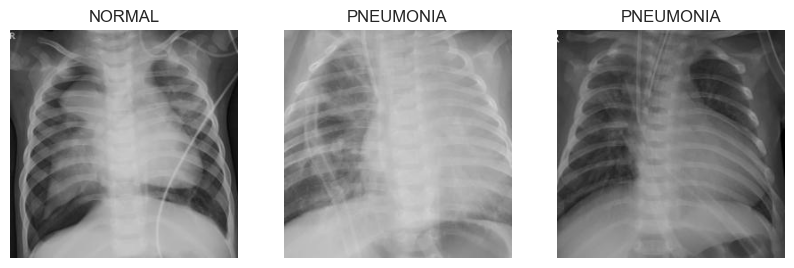

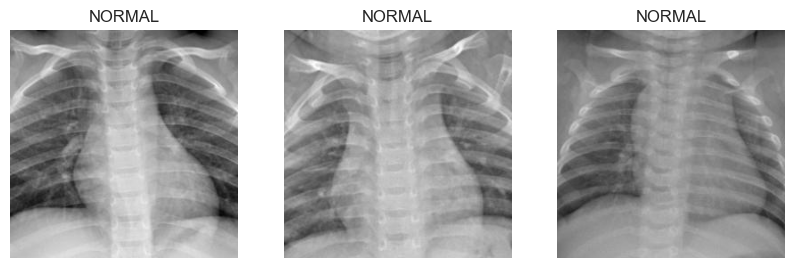

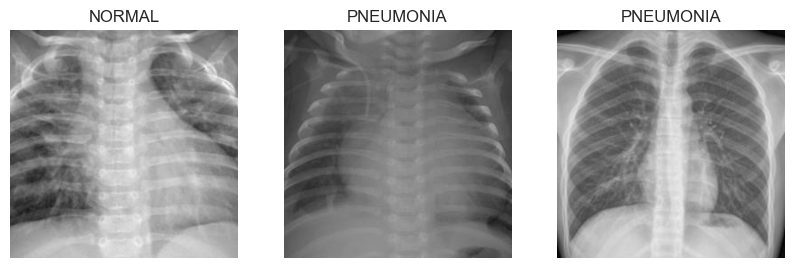

In [ ]:
# Visualize the images from the generator
aug_printing_samples(aug_train_datagen)
aug_printing_samples(aug_val_datagen)
aug_printing_samples(aug_test_datagen)


### **DenseNet121 Model**

I am repeating what I did in the portion just that now I am training on the augmented dataset

In [ ]:
optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

# DenseNet Model
densed_Model = DenseNet121(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in densed_Model.layers[:101]:    
    layer.trainable = False

for layer in densed_Model.layers[101:]:  
    layer.trainable = True


tfDense_model = tf.keras.Sequential()
tfDense_model.add(densed_Model)
tfDense_model.add(Flatten())
tfDense_model.add(BatchNormalization())
tfDense_model.add(Dense(256, activation='relu'))
tfDense_model.add(Dropout(0.3))
tfDense_model.add(BatchNormalization())
tfDense_model.add(Dense(128, activation='relu'))
tfDense_model.add(Dropout(0.3))
tfDense_model.add(BatchNormalization())
tfDense_model.add(Dense(64, activation='relu'))
tfDense_model.add(Dropout(0.3))
tfDense_model.add(BatchNormalization())
tfDense_model.add(Dense(32, activation='relu'))
tfDense_model.add(Dropout(0.3))
tfDense_model.add(Dense(2, activation='softmax'))


tfDense_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


# Train the model
tfDense_model.fit(aug_train_datagen, epochs=epoch, validation_data=aug_val_datagen, callbacks=[early_stoppage,lrs])

tfDense_model.summary()

tfDense_model.save('./augment_model/denseNet121/denseNetModel.h5')
tfDense_model.save_weights('./augment_model/denseNet121/denseNetWeights.h5')


Epoch 1/30


2023-03-28 13:33:14.356236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - ETA: 0s - loss: 0.7787 - accuracy: 0.5711

2023-03-28 13:34:58.143773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 120s 794ms/step - loss: 0.7787 - accuracy: 0.5711 - val_loss: 1.2363 - val_accuracy: 0.1282 - lr: 1.0000e-04
Epoch 2/30
123/123 [==============================] - 61s 491ms/step - loss: 0.3384 - accuracy: 0.8655 - val_loss: 1.6044 - val_accuracy: 0.0385 - lr: 1.0000e-04
Epoch 3/30
123/123 [==============================] - 62s 501ms/step - loss: 0.1921 - accuracy: 0.9614 - val_loss: 1.9144 - val_accuracy: 0.0449 - lr: 1.0000e-04
Epoch 4/30
123/123 [==============================] - 61s 493ms/step - loss: 0.1261 - accuracy: 0.9842 - val_loss: 2.2164 - val_accuracy: 0.0256 - lr: 1.0000e-04
Epoch 5/30
123/123 [==============================] - 59s 480ms/step - loss: 0.0892 - accuracy: 0.9905 - val_loss: 2.1609 - val_accuracy: 0.1154 - lr: 1.0000e-04
Epoch 6/30
123/123 [==============================] - 60s 485ms/step - loss: 0.0654 - accuracy: 0.9936 - val_loss: 2.1720 - val_accuracy: 0.1282 - lr: 1.0000e-04
Epoch 7/30
123/123 [==================

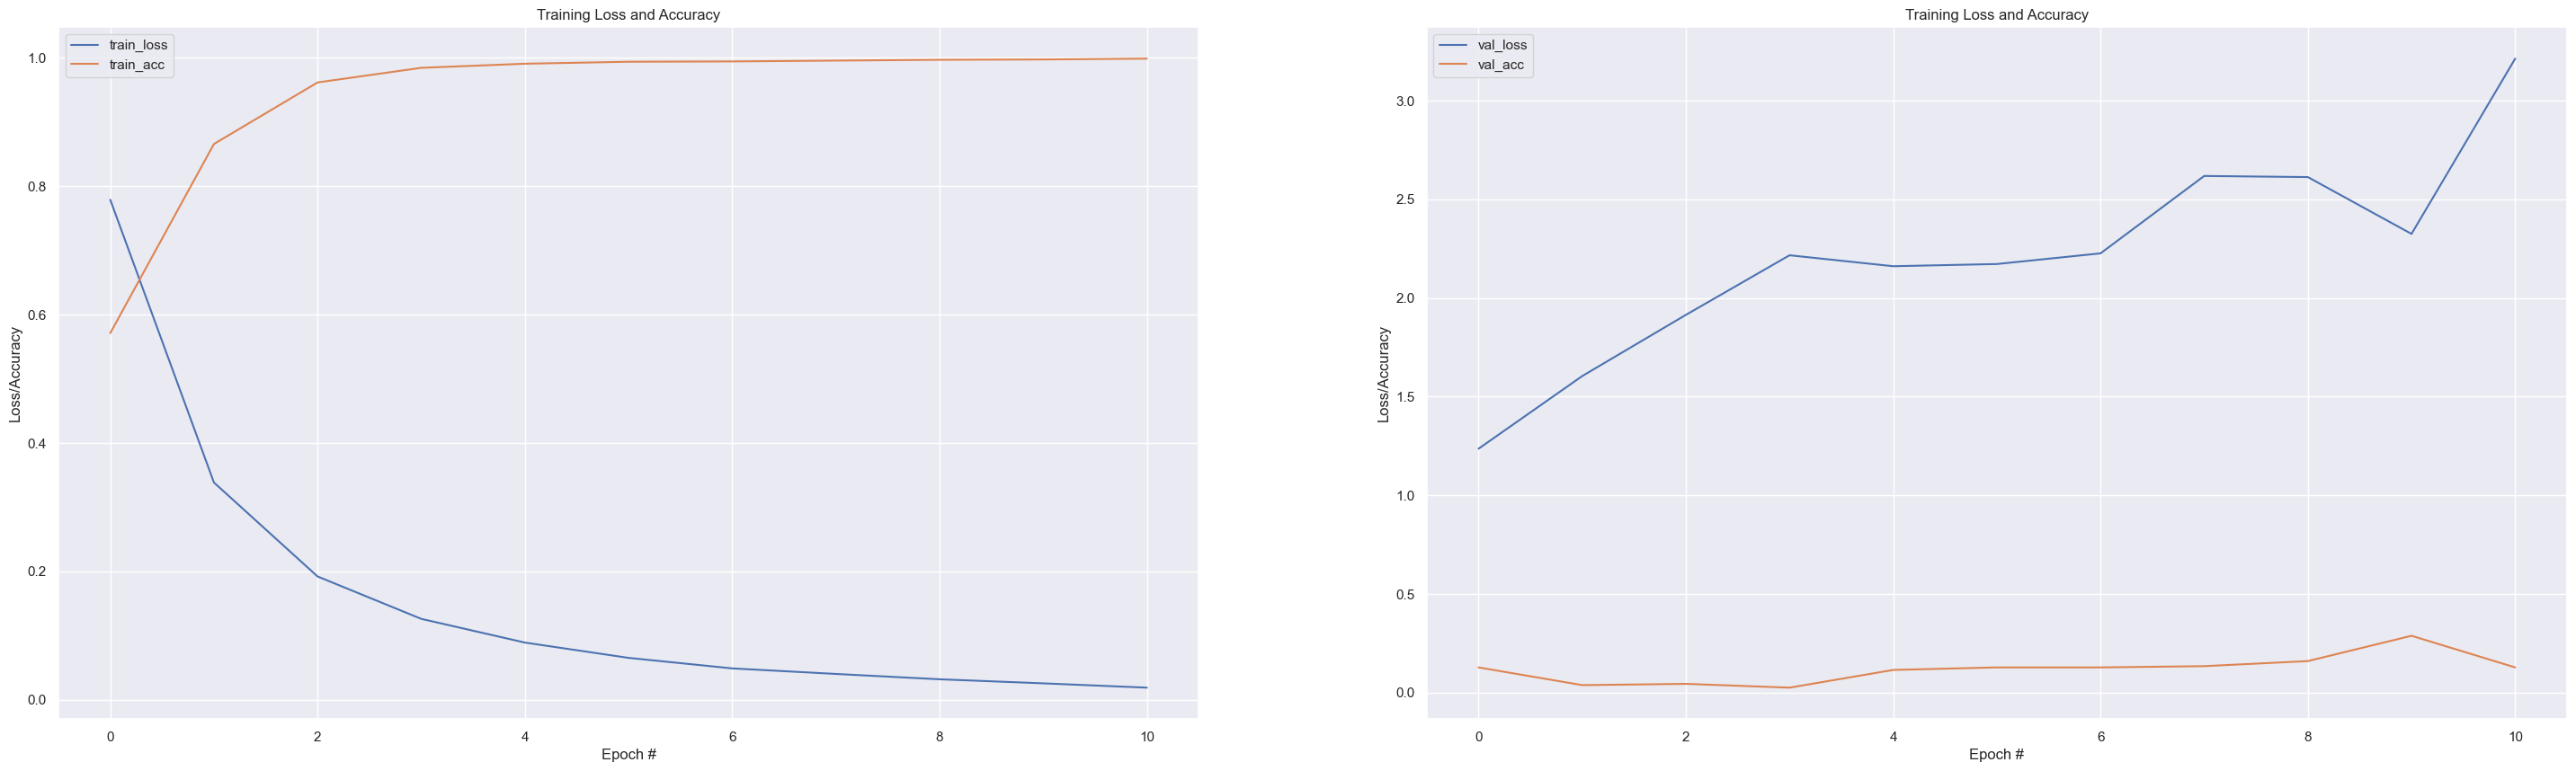

In [ ]:
# Plotting the loss and accuracy
iteration = np.arange(0, 11)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, tfDense_model.history.history["loss"], label="train_loss")
plt.plot(iteration, tfDense_model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, tfDense_model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, tfDense_model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

As we can see the model perform worse than expected. The losses are very high and the accuracy just simply took a nose-dive 

In [ ]:
# load the model
model_load_dense = tf.keras.models.load_model('./augment_model/denseNet121/denseNetModel.h5')
model_load_dense.load_weights('./augment_model/denseNet121/denseNetWeights.h5')

# Evaluate the model
loss , accuracy = model_load_dense.evaluate(test_datagen)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

2023-03-28 13:47:22.402333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 22s 723ms/step - loss: 0.6625 - accuracy: 0.7855
Loss: 0.6625
Accuracy: 0.7855


In [ ]:
# Evaluate the model
loss , accuracy = model_load_dense.evaluate(aug_test_datagen)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

20/20 [==============================] - 10s 475ms/step - loss: 1.2307 - accuracy: 0.6683
Loss: 1.2307
Accuracy: 0.6683


In [ ]:
print(_augment_confusion_matrix(model_load_dense, test_datagen)[1])

2023-03-28 13:48:10.193055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      NORMAL       0.51      0.29      0.37       317
   PNEUMONIA       0.50      0.72      0.59       317

    accuracy                           0.50       634
   macro avg       0.51      0.50      0.48       634
weighted avg       0.51      0.50      0.48       634



In [ ]:
print(_augment_confusion_matrix(model_load_dense, aug_test_datagen)[1])

              precision    recall  f1-score   support

      NORMAL       0.48      0.06      0.10       234
   PNEUMONIA       0.63      0.96      0.76       390

    accuracy                           0.62       624
   macro avg       0.56      0.51      0.43       624
weighted avg       0.57      0.62      0.51       624



(0.0, 2.0, 2.0, 0.0)

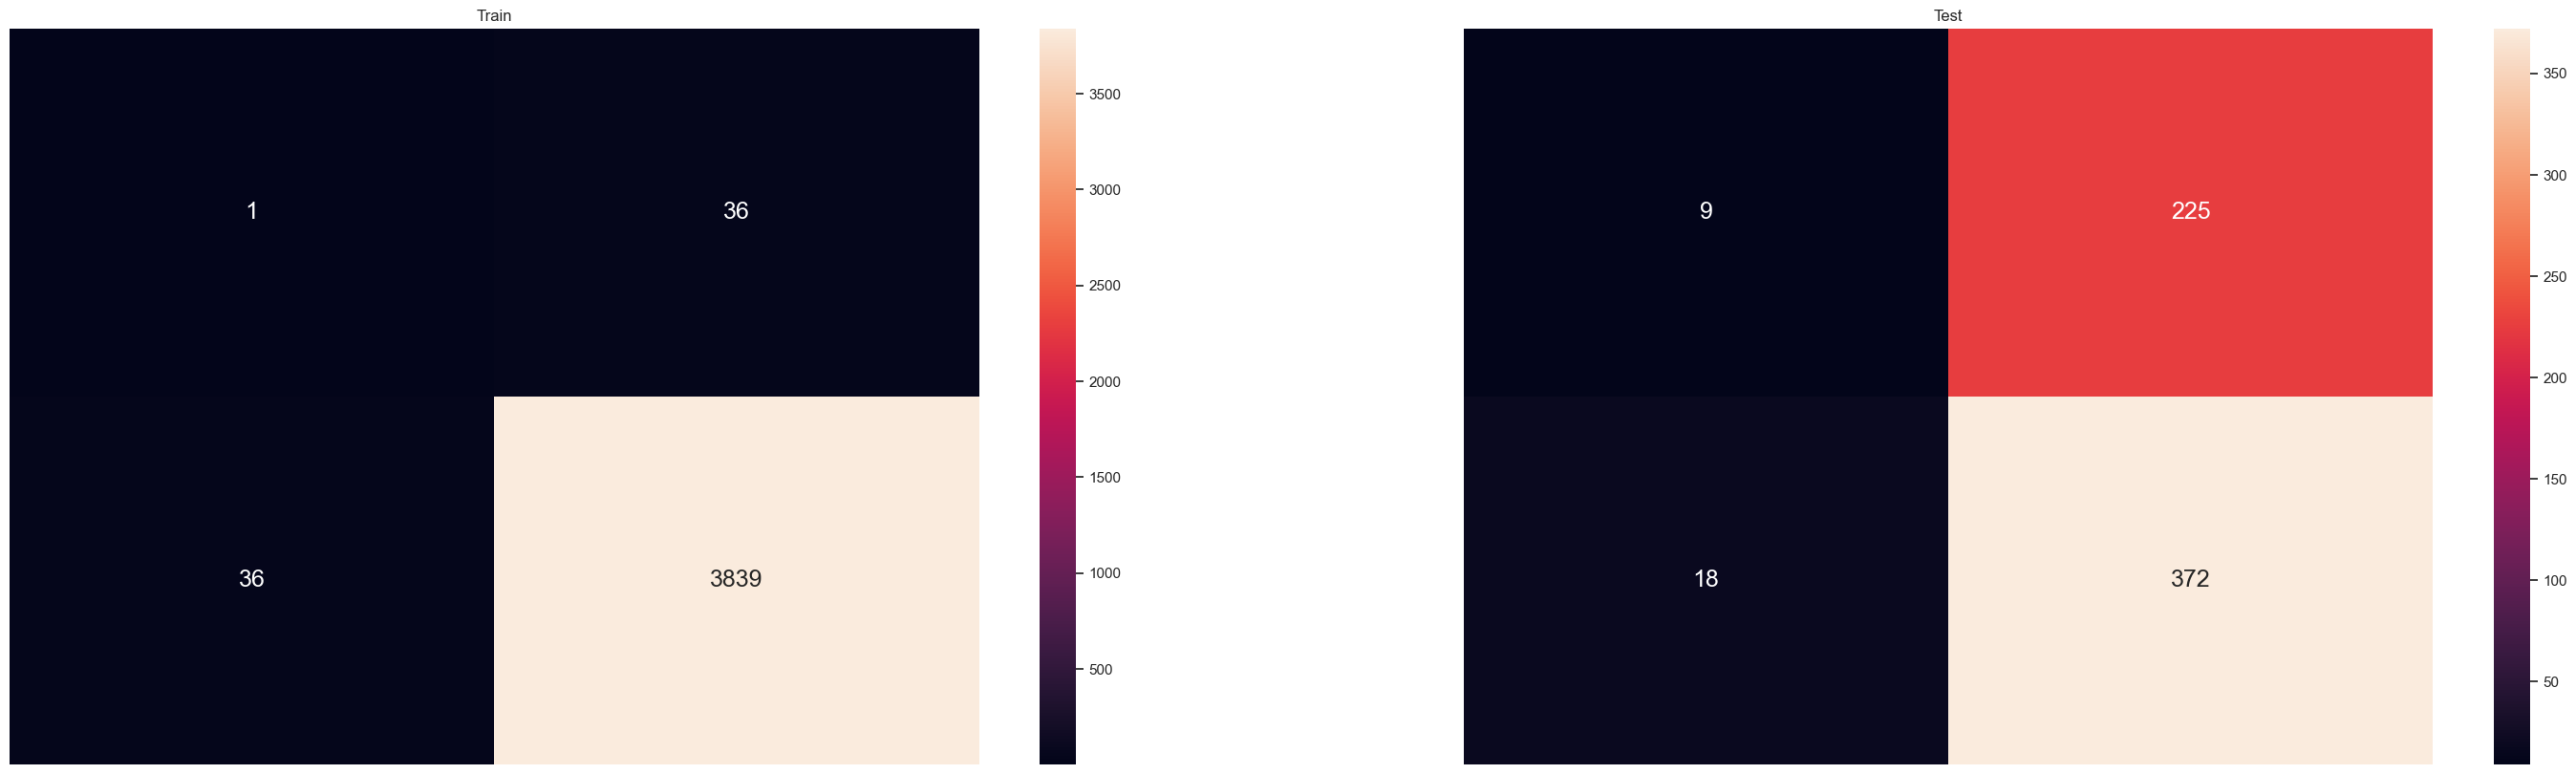

In [ ]:
# Confusion matrix

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_augment_confusion_matrix(model_load_dense, aug_train_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_augment_confusion_matrix(model_load_dense, aug_test_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

2023-03-28 13:50:51.796009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(-0.5, 255.5, 255.5, -0.5)

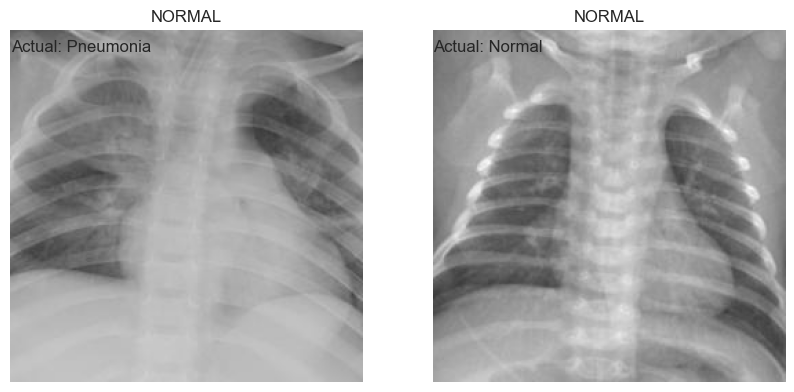

In [ ]:
# load the model
model_load = tf.keras.models.load_model('./augment_model/denseNet121/denseNetModel.h5')
model_load.load_weights('./augment_model/denseNet121/denseNetWeights.h5')

image = tf.keras.utils.load_img('./crop_images/test/NORMAL/' + random.choice(os.listdir('./crop_images/test/NORMAL/')), target_size=(256, 256))
preds = np.argmax(model_load.predict_generator(np.expand_dims(image, axis=0), verbose=0), axis=-1) 

image_pn = tf.keras.utils.load_img('./crop_images/test/PNEUMONIA/' + random.choice(os.listdir('./crop_images/test/PNEUMONIA/')), target_size=(256, 256))
pred_pn = np.argmax(model_load.predict_generator(np.expand_dims(image_pn, axis=0), verbose=0), axis=-1) 


class_dictionary = test_datagen.class_indices
class_dictionary = { value:key for key,value in class_dictionary.items()}
class_list = [value for _,value in class_dictionary.items()]

image_batch = test_datagen.next()

plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 2, 1)
plt.imshow(image_pn)
plt.title(class_list[pred_pn.argmax()])
plt.text(0,15,"Actual: Pneumonia")
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title(class_list[preds.argmax()])
plt.text(0,15,"Actual: Normal")
plt.axis("off")

Even though it somehow manages to get 1/2 of our test images correct. But on a larger scale, it is worst off comapred to our model that my team did when we undersample our dataset

### **ResNet50 Model**

In [ ]:
# ResNet50 Model

optimizer = Adam(learning_rate=1e-4)
lrs = tf.keras.callbacks.ReduceLROnPlateau()
loss = tf.keras.losses.CategoricalCrossentropy()
int_lr = 0.0001
epoch = 30
batch_size = 32

# Early Stopping helps to stop the training process when the model stops improving. This is to reduce the amount of time needed to train over nuance changes in the model. 
early_stoppage = EarlyStopping(monitor='val_loss', patience=10)

# DenseNet Model
res_Model = ResNet50(include_top=False,input_tensor= tf.keras.Input(shape=(256,256,3)), weights='imagenet')


# Freeze the layers
for layer in res_Model.layers[:101]:    
    layer.trainable = False

for layer in res_Model.layers[101:]:  
    layer.trainable = True


tfRes_model = tf.keras.Sequential()
tfRes_model.add(res_Model)
tfRes_model.add(Flatten())
tfRes_model.add(BatchNormalization())
tfRes_model.add(Dense(256, activation='relu'))
tfRes_model.add(Dropout(0.3))
tfRes_model.add(BatchNormalization())
tfRes_model.add(Dense(128, activation='relu'))
tfRes_model.add(Dropout(0.3))
tfRes_model.add(BatchNormalization())
tfRes_model.add(Dense(64, activation='relu'))
tfRes_model.add(Dropout(0.3))
tfRes_model.add(BatchNormalization())
tfRes_model.add(Dense(32, activation='relu'))
tfRes_model.add(Dropout(0.3))
tfRes_model.add(Dense(2, activation='softmax'))


tfRes_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
tfRes_model.fit(aug_train_datagen, epochs=epoch, validation_data=aug_val_datagen, callbacks=[early_stoppage,lrs])

tfRes_model.summary()

tfRes_model.save('./augment_model/resNet50/resNet50Model.h5')
tfRes_model.save_weights('./augment_model/resNet50/resNet50Weights.h5')



Epoch 1/30


2023-03-28 13:52:14.339813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.6253

2023-03-28 13:53:23.847546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 80s 563ms/step - loss: 0.7457 - accuracy: 0.6253 - val_loss: 0.4096 - val_accuracy: 0.8205 - lr: 1.0000e-04
Epoch 2/30
123/123 [==============================] - 45s 362ms/step - loss: 0.3808 - accuracy: 0.8456 - val_loss: 1.5802 - val_accuracy: 0.0641 - lr: 1.0000e-04
Epoch 3/30
123/123 [==============================] - 43s 351ms/step - loss: 0.2275 - accuracy: 0.9389 - val_loss: 1.7694 - val_accuracy: 0.0128 - lr: 1.0000e-04
Epoch 4/30
123/123 [==============================] - 43s 353ms/step - loss: 0.1468 - accuracy: 0.9752 - val_loss: 2.2158 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/30
123/123 [==============================] - 44s 354ms/step - loss: 0.1053 - accuracy: 0.9854 - val_loss: 2.5482 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 6/30
123/123 [==============================] - 45s 367ms/step - loss: 0.0807 - accuracy: 0.9898 - val_loss: 2.6321 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 7/30
123/123 [=======

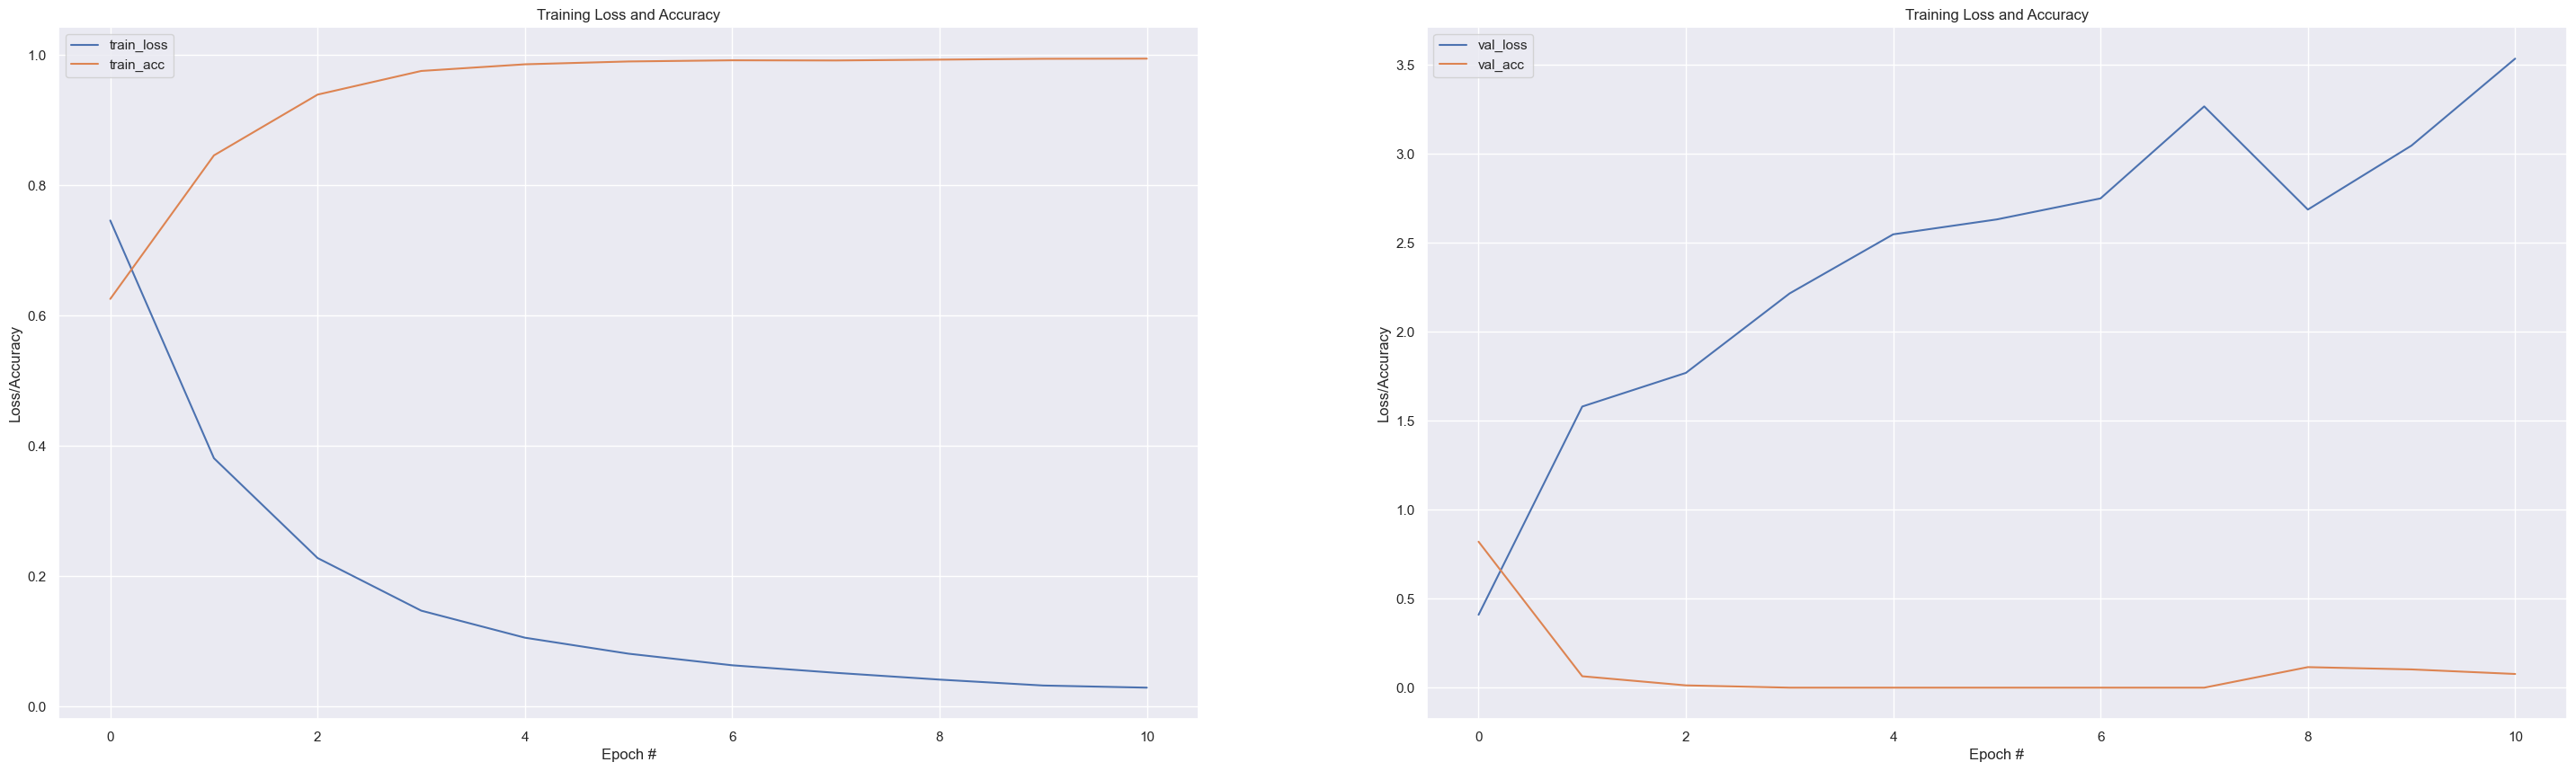

In [ ]:
# Plotting the loss and accuracy
iteration = np.arange(0, 11)

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, tfRes_model.history.history["loss"], label="train_loss")
plt.plot(iteration, tfRes_model.history.history["accuracy"], label="train_acc")
plt.legend()


ax = plt.subplot(1, 2, 2)
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.plot(iteration, tfRes_model.history.history["val_loss"], label="val_loss")
plt.plot(iteration, tfRes_model.history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# load the model
model_load_res = tf.keras.models.load_model('./augment_model/resNet50/resNet50Model.h5')
model_load_res.load_weights('./augment_model/resNet50/resNet50Weights.h5')

# Evaluate the model
loss , accuracy = model_load_res.evaluate(test_datagen)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

print(_augment_confusion_matrix(model_load_res, test_datagen)[1])


2023-03-28 14:08:36.055728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 13s 504ms/step - loss: 1.1037 - accuracy: 0.6625
Loss: 1.1037
Accuracy: 0.6625


2023-03-28 14:08:49.170010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      NORMAL       0.48      0.15      0.23       317
   PNEUMONIA       0.50      0.83      0.62       317

    accuracy                           0.49       634
   macro avg       0.49      0.49      0.43       634
weighted avg       0.49      0.49      0.43       634



In [ ]:
# Evaluate the model
loss , accuracy = model_load_res.evaluate(aug_test_datagen)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

print(_augment_confusion_matrix(model_load_res, aug_test_datagen)[1])

20/20 [==============================] - 7s 341ms/step - loss: 1.3619 - accuracy: 0.6490
Loss: 1.3619
Accuracy: 0.6490
              precision    recall  f1-score   support

      NORMAL       0.40      0.03      0.05       234
   PNEUMONIA       0.63      0.98      0.76       390

    accuracy                           0.62       624
   macro avg       0.51      0.50      0.41       624
weighted avg       0.54      0.62      0.49       624



(0.0, 2.0, 2.0, 0.0)

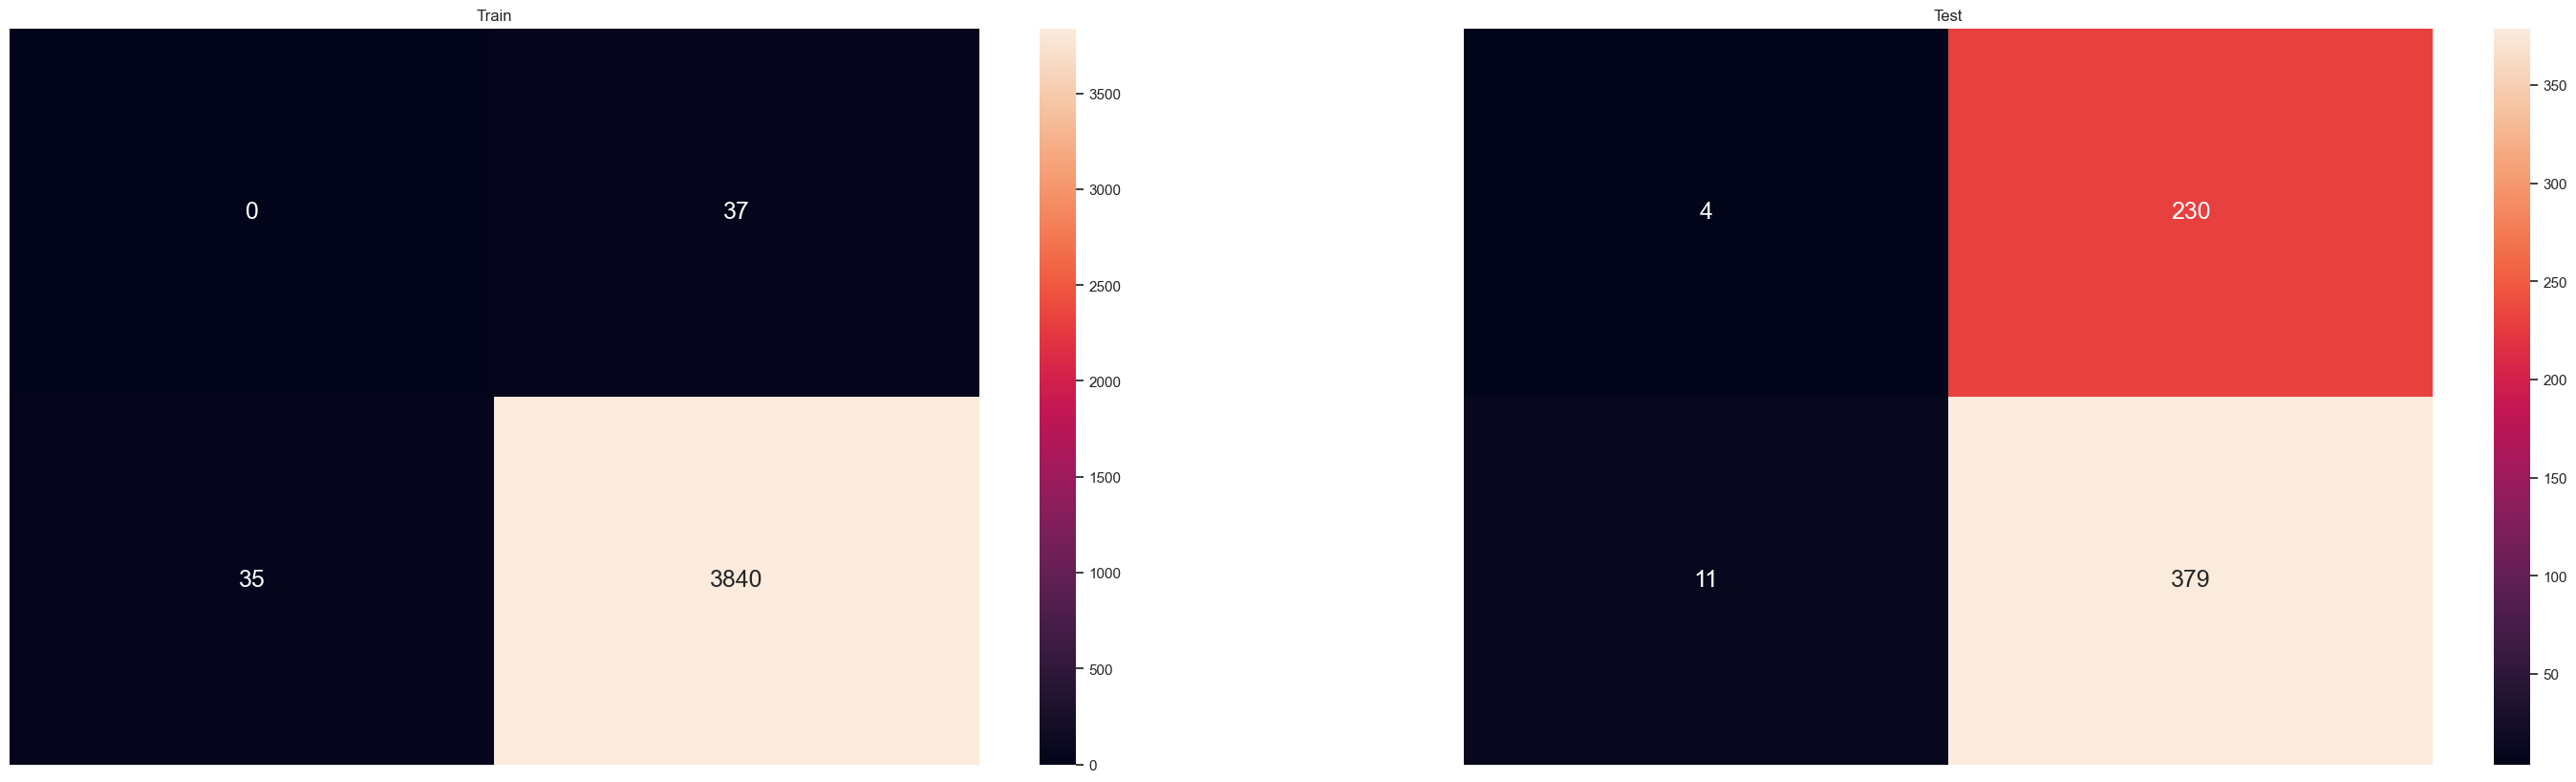

In [ ]:
# Confusion matrix

plt.figure(figsize=(36, 10))
ax = plt.subplot(1, 2, 1)
plt.title("Train")
sb.heatmap(_augment_confusion_matrix(model_load_res, aug_train_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.title("Test")
sb.heatmap(_augment_confusion_matrix(model_load_res, aug_test_datagen)[0], annot = True, fmt=".0f", annot_kws={"size": 18})
plt.axis("off")

2023-03-28 14:19:17.493544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(-0.5, 255.5, 255.5, -0.5)

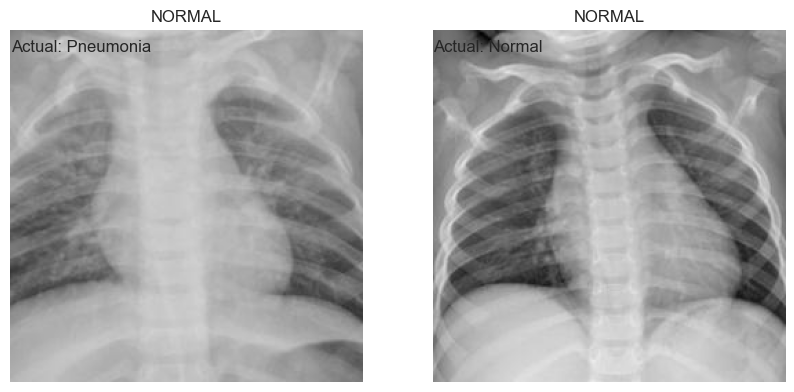

In [ ]:
# load the model
model_load = tf.keras.models.load_model('./augment_model/resNet50/resNet50Model.h5')
model_load.load_weights('./augment_model/resNet50/resNet50Weights.h5')

image = tf.keras.utils.load_img('./crop_images/test/NORMAL/' + random.choice(os.listdir('./crop_images/test/NORMAL/')), target_size=(256, 256))
preds = np.argmax(model_load.predict_generator(np.expand_dims(image, axis=0), verbose=0), axis=-1) 

image_pn = tf.keras.utils.load_img('./crop_images/test/PNEUMONIA/' + random.choice(os.listdir('./crop_images/test/PNEUMONIA/')), target_size=(256, 256))
pred_pn = np.argmax(model_load.predict_generator(np.expand_dims(image_pn, axis=0), verbose=0), axis=-1) 


class_dictionary = test_datagen.class_indices
class_dictionary = { value:key for key,value in class_dictionary.items()}
class_list = [value for _,value in class_dictionary.items()]

image_batch = test_datagen.next()

plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 2, 1)
plt.imshow(image_pn)
plt.title(class_list[pred_pn.argmax()])
plt.text(0,15,"Actual: Pneumonia")
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title(class_list[preds.argmax()])
plt.text(0,15,"Actual: Normal")
plt.axis("off")